<img src='imgs/OOIPY_Logo.png' align="right" width=100>

# OOIPY Demo
This script goes over some of the basic functionality of OOIPY.
## Demo Sections:
- Download Broadband Acoustic Data off of OOI Data Server
- Calculate and Plot Spectrogram and PSDs
- Using Noise Interferometry Toolbox

First let's download some dependancies.

In [3]:
#Import All Dependancies
import numpy as np
from matplotlib import pyplot as plt
import datetime
import time
#from request import hydrophone
import os
import sys
from ooipy.request.hydrophone_request import get_acoustic_data
import ooipy


# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

# Short tutorial on how to pull data using multithreading and how to compute PSD estimates

In [8]:
#Specify Time Window Desired and Hydrophone Node
starttime = datetime.datetime(2017,3,20,0,0,0) # time of first sample
endtime = datetime.datetime(2017,3,20,0,1,0) # time of last sample
node = '/LJ01C'

# pulling data using multithreading. Function returns a mask array, but for further processing, the mask
# array can be treated like a regular numpy array
# hyd_data is an ooipy.hydrophone.basic.HydrophoneData object
hyd_data = ooipy.request.hydrophone.get_acoustic_data(starttime, endtime, node=node, data_gap_mode=1)

#computing PSD 
psd = hyd_data.compute_psd_welch()

# psd is object with freqs and values attribute
# psd can also be accesed by hyd_data.psd after calling compute_psd_welch() function
print(psd.values)
print(hyd_data.psd.values)

[ 66.74896857  75.69934991  77.25608625 ..., -13.01373505 -12.63419977
 -18.082648  ]
[ 66.74896857  75.69934991  77.25608625 ..., -13.01373505 -12.63419977
 -18.082648  ]


## Download Broadband Acoustic Data off of OOI Data Server

In [6]:
#Specify Time Window Desired and Hydrophone Node
starttime = datetime.datetime(2017,3,20,0,0,0) # time of first sample
endtime = datetime.datetime(2017,3,20,0,0,10) # time of last sample
node = '/LJ01C'

hyd_data = get_acoustic_data(starttime, endtime, node=node, data_gap_mode=1, verbose=True)

Fetching URLs...
Sorting valid URLs for Time Window...
Data has Gaps


type:  <class 'ooipy.hydrophone.basic.HydrophoneData'> 

stats:           network: OO
         station: HYEA1
        location: /LJ01C
         channel: YDH
       starttime: 2017-03-20T00:00:00.000000Z
         endtime: 2017-03-20T00:00:10.000000Z
   sampling_rate: 64000.0
           delta: 1.5625e-05
            npts: 640001
           calib: 1.0
         _format: MSEED
           mseed: AttribDict({'dataquality': 'D', 'number_of_records': 9473, 'encoding': 'STEIM2', 'byteorder': '>', 'record_length': 4096, 'filesize': 38801408})
      processing: ['ObsPy 1.2.1: trim(endtime=UTCDateTime(2017, 3, 20, 0, 0, 10)::fill_value=None::nearest_sample=True::pad=False::starttime=UTCDateTime(2017, 3, 20, 0, 0))'] 

data:  [-27008.0 -26671.0 -27191.0 ..., -27677.0 -27241.0 -26136.0] 



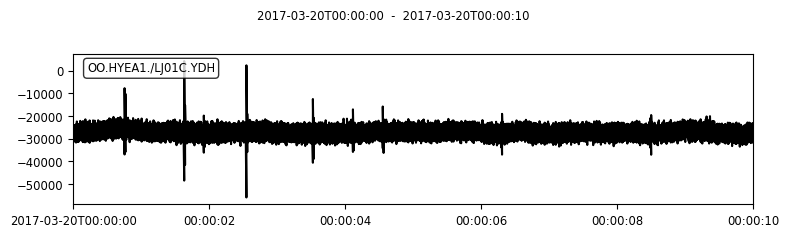

In [7]:
# Access attributes of hyd_data
print('type: ', type(hyd_data), '\n')
print('stats: ', hyd_data.stats, '\n')
print('data: ', hyd_data.data, '\n')

p1 = hyd_data.plot()

## Compute and Visualize Spectrograms

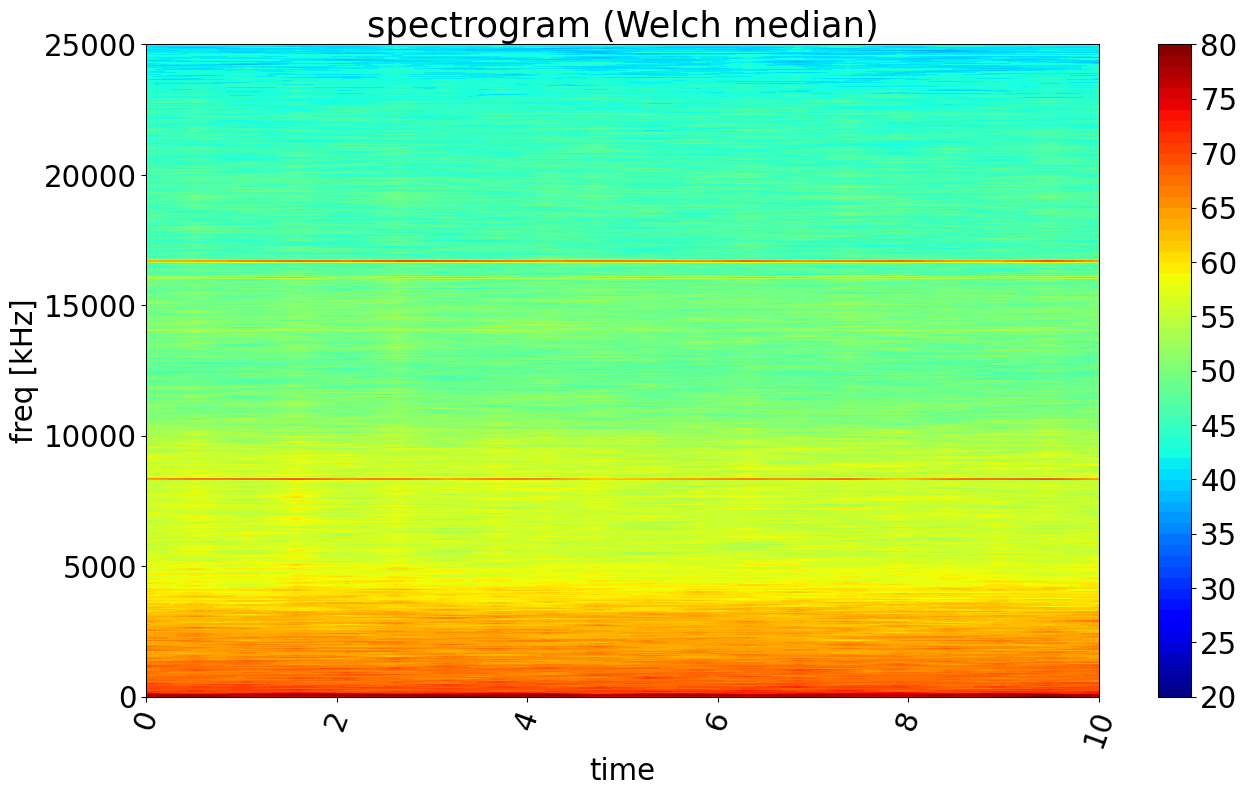

In [18]:
# 1. Welch median over a data segment of 0.5s is used to compute the spectrum at each bin
# of the spectrogram
hyd_data.compute_spectrogram(avg_time=0.5)
hyd_data.spectrogram.time = np.linspace(0, 10, len(hyd_data.spectrogram.time))
hyd_data.spectrogram.visualize(title='spectrogram (Welch median)', ylabel='freq [kHz]',
                           fmin=0, fmax=25000, vmin=20, vmax=80)



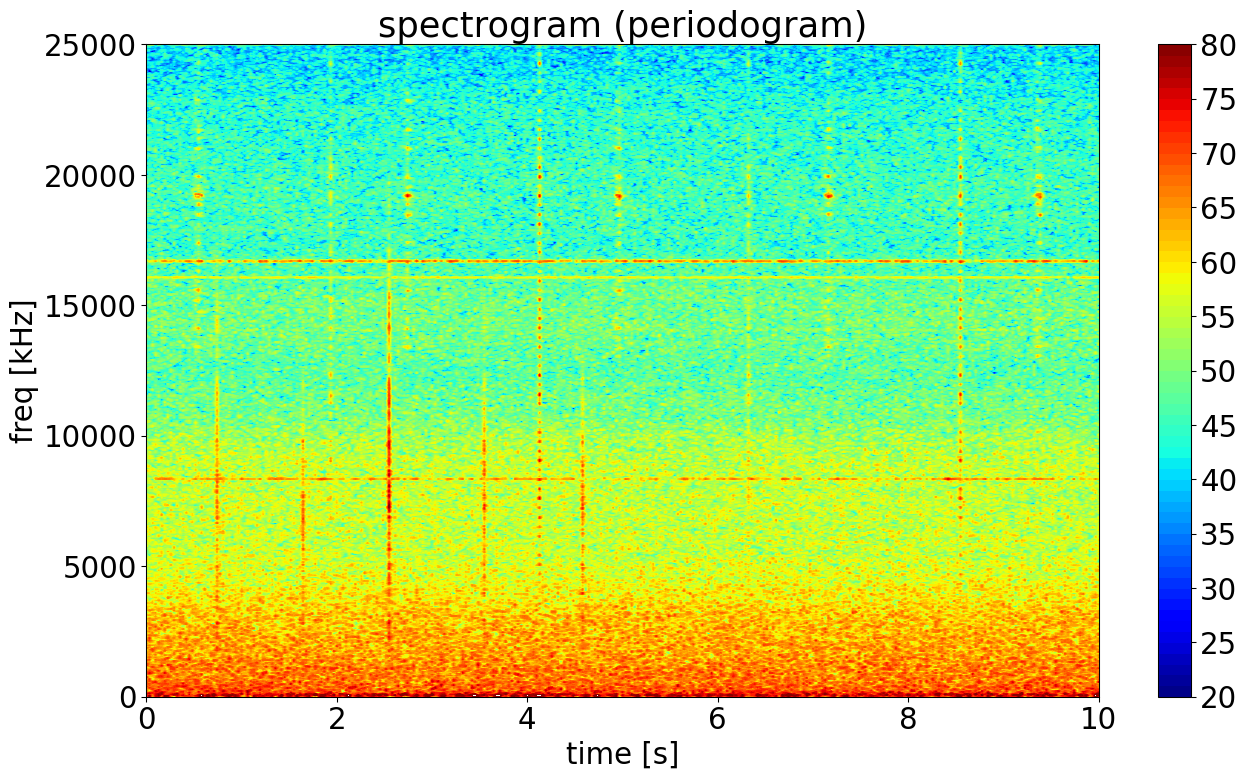

In [17]:
# 2. Periodogram estimate is used to compute the spectrum at each bin of the spectrogram
# To do so, the parameter avg_time is set to None (default). The amount of data are reduced to
# 10s to avoid memory overflow while plotting the data.

hyd_data.compute_spectrogram(L=2048)

hyd_data.spectrogram.time = np.linspace(0, 10, len(hyd_data.spectrogram.time))
hyd_data.spectrogram.visualize(title='spectrogram (periodogram)', ylabel='freq [kHz]',
               xlabel='time [s]', fmin=0, fmax=25000, vmin=20, vmax=80, xlabel_rot=0)

## Compute and Visualize PSDs

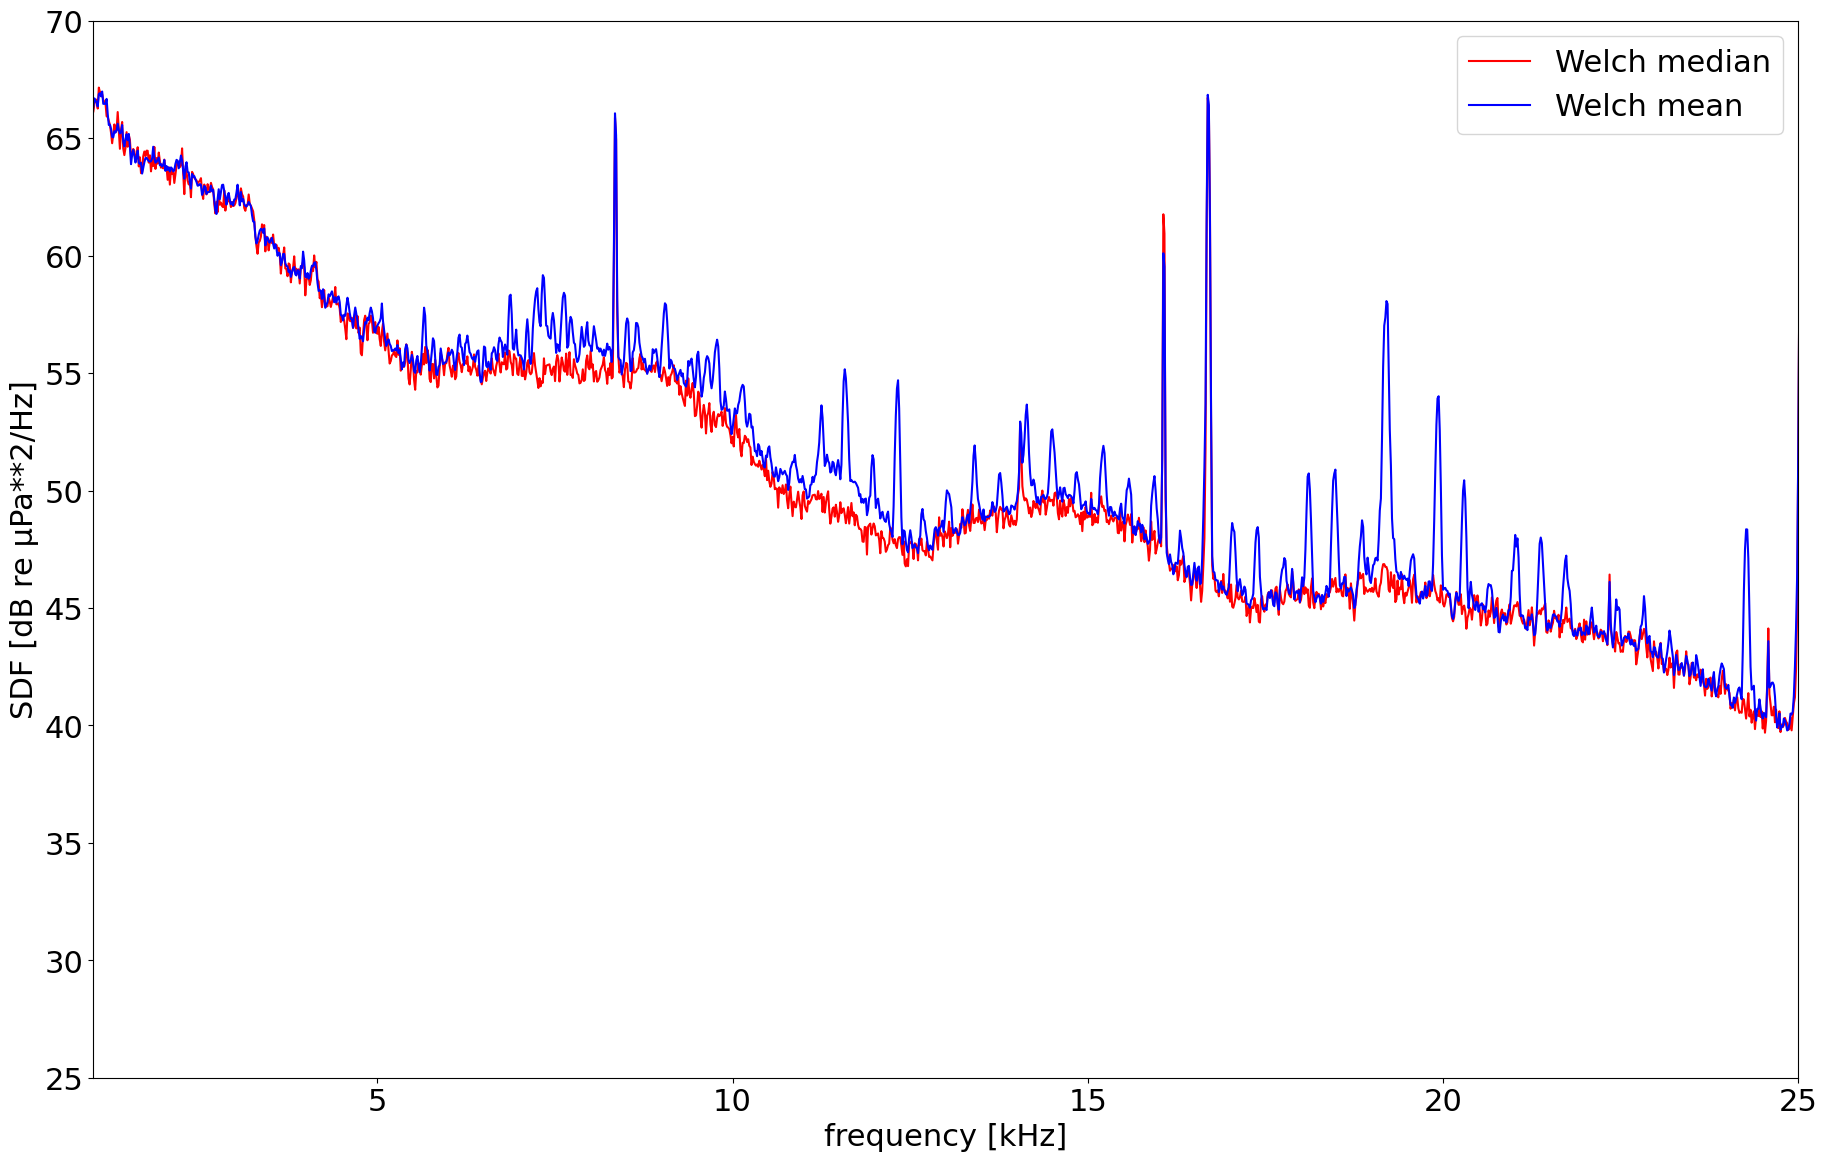

In [22]:
# power spectral density estimate of noise data using Welch's method
fig, ax = plt.subplots(figsize=(22,14), dpi=100)

# 1. using median averaging (default)
hyd_data.compute_psd_welch()

f = hyd_data.psd.freq / 1000
plt.plot(f, hyd_data.psd.values, label='Welch median',color='r')

# 2. using mean averaging
hyd_data.compute_psd_welch(avg_method='mean')

plt.plot(f, hyd_data.psd.values, label='Welch mean',color='b')
plt.xlabel('frequency [kHz]')
plt.ylabel('SDF [dB re µPa**2/Hz]')
plt.xlim(1,25)
plt.ylim(25,70)
plt.legend()

## Calculate Spectrograms and PSDs using multiprocessing.

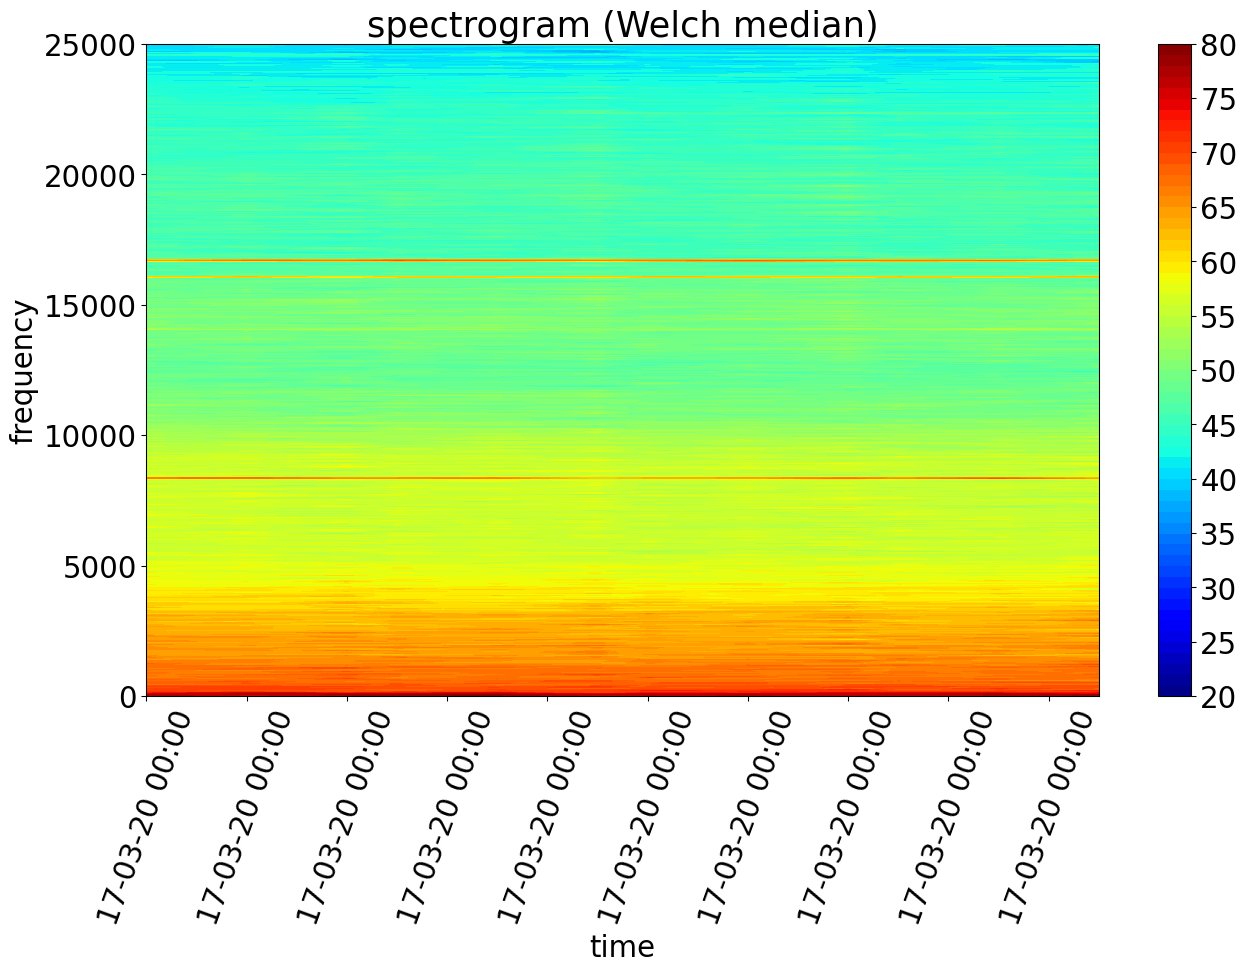

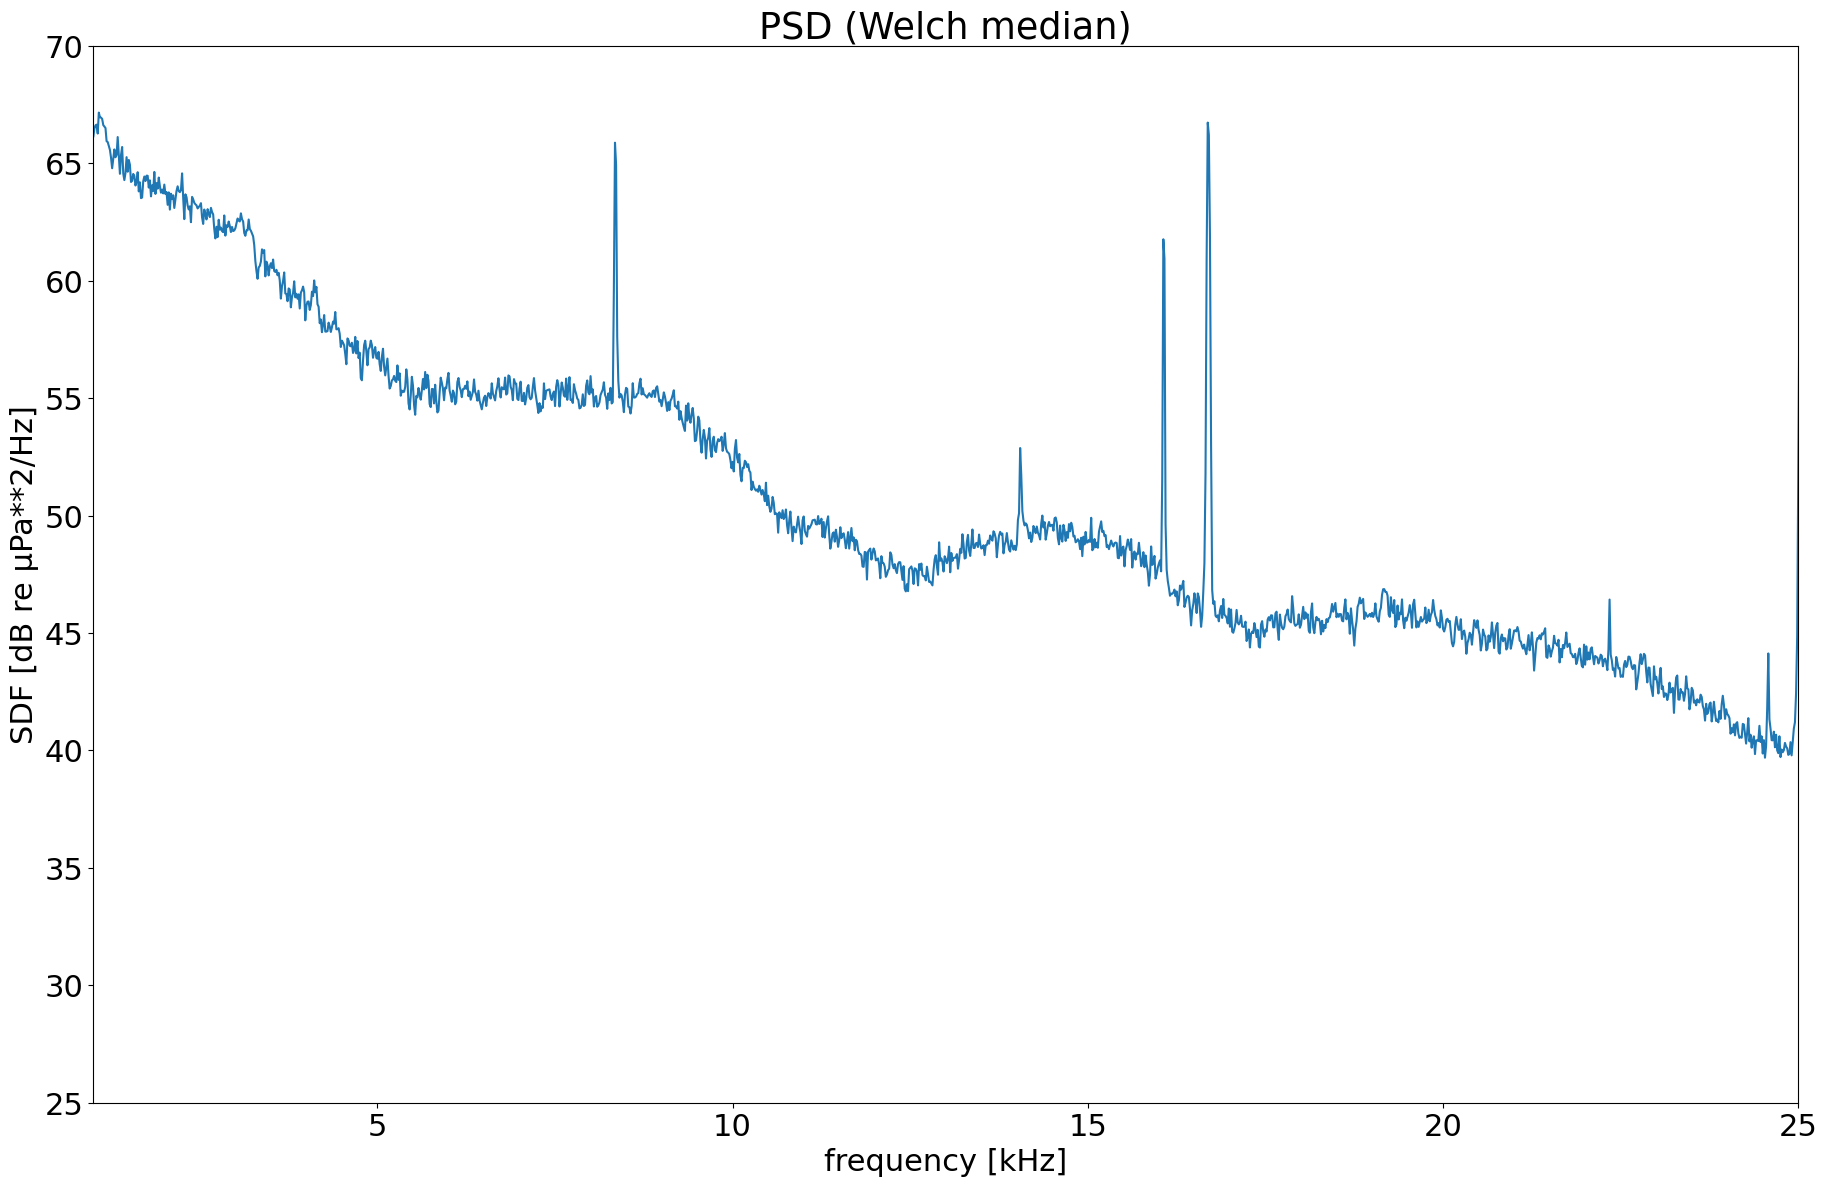

In [24]:
# spectrogram
hyd_data.compute_spectrogram_mp(avg_time=1)
hyd_data.spectrogram.visualize(title='spectrogram (Welch median)', fmin=0, fmax=25000, vmin=20, vmax=80)

# PSD
# Here, each segment has a length of 300s. For each segment a separate PSD estimate is 
# returned.
hyd_data.compute_psd_welch_mp(300)

fig, ax = plt.subplots(figsize=(22,14), dpi=100)
f = hyd_data.psd_list[0].freq / 1000
for psd in hyd_data.psd_list:
    plt.plot(f, psd.values)
    
plt.xlabel('frequency [kHz]')
plt.ylabel('SDF [dB re µPa**2/Hz]')
plt.title('PSD (Welch median)')
plt.xlim(1,25)
plt.ylim(25,70)
plt.show()